In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

import keras
from keras import layers
from keras import ops

AUTOTUNE = tf.data.AUTOTUNE

2025-10-26 14:42:20.262104: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Download DIV2K from TF Datasets
# Using bicubic 4x degradation type
div2k_data = tfds.image.Div2k(config="bicubic_x4")
div2k_data.download_and_prepare()

# Taking train data from div2k_data object
train = div2k_data.as_dataset(split="train", as_supervised=True)
train_cache = train.cache()
# Validation data
val = div2k_data.as_dataset(split="validation", as_supervised=True)
val_cache = val.cache()

I0000 00:00:1761486142.587860   23357 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8878 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:08:00.0, compute capability: 7.5


In [3]:
def flip_left_right(lowres_img, highres_img):
    """Flips Images to left and right."""

    # Outputs random values from a uniform distribution in between 0 to 1
    rn = keras.random.uniform(shape=(), maxval=1)
    # If rn is less than 0.5 it returns original lowres_img and highres_img
    # If rn is greater than 0.5 it returns flipped image
    return ops.cond(
        rn < 0.5,
        lambda: (lowres_img, highres_img),
        lambda: (
            ops.flip(lowres_img),
            ops.flip(highres_img),
        ),
    )


def random_rotate(lowres_img, highres_img):
    """Rotates Images by 90 degrees."""

    # Outputs random values from uniform distribution in between 0 to 4
    rn = ops.cast(
        keras.random.uniform(shape=(), maxval=4, dtype="float32"), dtype="int32"
    )
    # Here rn signifies number of times the image(s) are rotated by 90 degrees
    return tf.image.rot90(lowres_img, rn), tf.image.rot90(highres_img, rn)


def random_crop(lowres_img, highres_img, hr_crop_size=96, scale=4):
    """Crop images.

    low resolution images: 24x24
    high resolution images: 96x96
    """
    lowres_crop_size = hr_crop_size // scale  # 96//4=24
    lowres_img_shape = ops.shape(lowres_img)[:2]  # (height,width)

    lowres_width = ops.cast(
        keras.random.uniform(
            shape=(), maxval=lowres_img_shape[1] - lowres_crop_size + 1, dtype="float32"
        ),
        dtype="int32",
    )
    lowres_height = ops.cast(
        keras.random.uniform(
            shape=(), maxval=lowres_img_shape[0] - lowres_crop_size + 1, dtype="float32"
        ),
        dtype="int32",
    )

    highres_width = lowres_width * scale
    highres_height = lowres_height * scale

    lowres_img_cropped = lowres_img[
        lowres_height : lowres_height + lowres_crop_size,
        lowres_width : lowres_width + lowres_crop_size,
    ]  # 24x24
    highres_img_cropped = highres_img[
        highres_height : highres_height + hr_crop_size,
        highres_width : highres_width + hr_crop_size,
    ]  # 96x96

    return lowres_img_cropped, highres_img_cropped

In [4]:
def dataset_object(dataset_cache, training=True):
    ds = dataset_cache
    ds = ds.map(
        lambda lowres, highres: random_crop(lowres, highres, scale=4),
        num_parallel_calls=AUTOTUNE,
    )

    if training:
        ds = ds.map(random_rotate, num_parallel_calls=AUTOTUNE)
        ds = ds.map(flip_left_right, num_parallel_calls=AUTOTUNE)
    # Batching Data
    ds = ds.batch(16)

    if training:
        # Repeating Data, so that cardinality if dataset becomes infinte
        ds = ds.repeat()
    # prefetching allows later images to be prepared while the current image is being processed
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds


train_ds = dataset_object(train_cache, training=True)
val_ds = dataset_object(val_cache, training=False)

2025-10-26 14:45:55.070118: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:396] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-10-26 14:45:55.565103: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: CANCELLED: RecvAsync is cancelled.
	 [[{{node AssignVariableOp/_9}}]] [type.googleapis.com/tensorflow.DerivedStatus='']
2025-10-26 14:45:55.565153: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: CANCELLED: RecvAsync is cancelled.
	 [[{{node AssignVariableOp/_9}}]] [type.googleapis.com/tensorflow.DerivedStatus='']
2025-10-26 14:45:55.565164: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 15434291049855647805
2025-10-26 14:45:55.565169: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 9364984668444884259
2025-10-26 14:45:55.56517

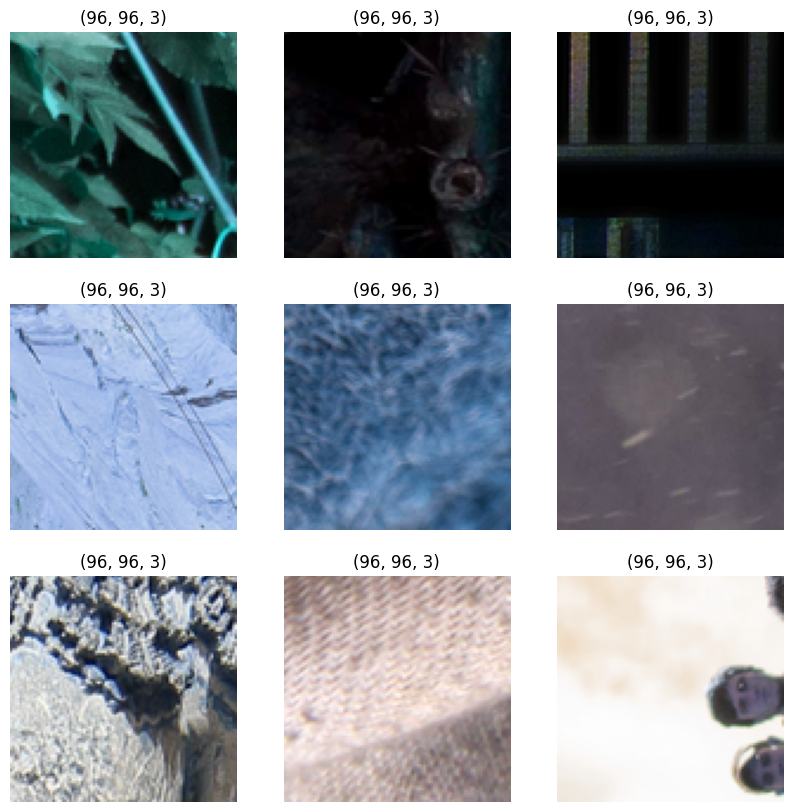

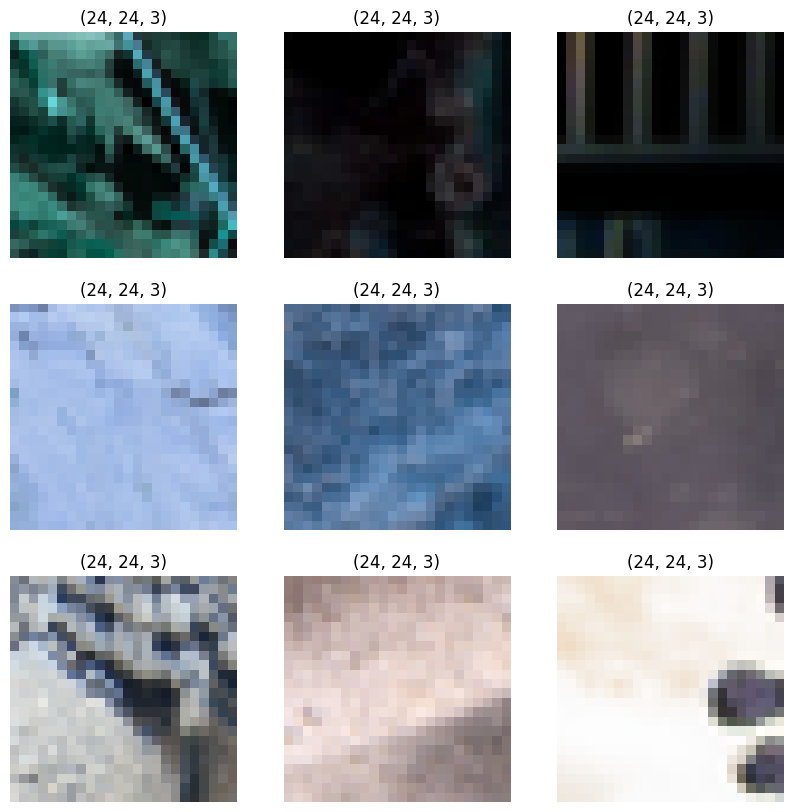

In [5]:
lowres, highres = next(iter(train_ds))

# High Resolution Images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(highres[i].numpy().astype("uint8"))
    plt.title(highres[i].shape)
    plt.axis("off")

# Low Resolution Images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(lowres[i].numpy().astype("uint8"))
    plt.title(lowres[i].shape)
    plt.axis("off")


def PSNR(super_resolution, high_resolution):
    """Compute the peak signal-to-noise ratio, measures quality of image."""
    # Max value of pixel is 255
    psnr_value = tf.image.psnr(high_resolution, super_resolution, max_val=255)[0]
    return psnr_value

In [6]:
class EDSRModel(keras.Model):
    def train_step(self, data):
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.
        x, y = data

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            # Compute the loss value
            # (the loss function is configured in `compile()`)
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(y, y_pred)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}

    def predict_step(self, x):
        # Adding dummy dimension using tf.expand_dims and converting to float32 using tf.cast
        x = ops.cast(tf.expand_dims(x, axis=0), dtype="float32")
        # Passing low resolution image to model
        super_resolution_img = self(x, training=False)
        # Clips the tensor from min(0) to max(255)
        super_resolution_img = ops.clip(super_resolution_img, 0, 255)
        # Rounds the values of a tensor to the nearest integer
        super_resolution_img = ops.round(super_resolution_img)
        # Removes dimensions of size 1 from the shape of a tensor and converting to uint8
        super_resolution_img = ops.squeeze(
            ops.cast(super_resolution_img, dtype="uint8"), axis=0
        )
        return super_resolution_img


# Residual Block
def ResBlock(inputs):
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(inputs)
    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.Add()([inputs, x])
    return x


# Upsampling Block
def Upsampling(inputs, factor=2, **kwargs):
    x = layers.Conv2D(64 * (factor**2), 3, padding="same", **kwargs)(inputs)
    x = layers.Lambda(lambda x: tf.nn.depth_to_space(x, block_size=factor))(x)
    x = layers.Conv2D(64 * (factor**2), 3, padding="same", **kwargs)(x)
    x = layers.Lambda(lambda x: tf.nn.depth_to_space(x, block_size=factor))(x)
    return x


def make_model(num_filters, num_of_residual_blocks):
    # Flexible Inputs to input_layer
    input_layer = layers.Input(shape=(None, None, 3))
    # Scaling Pixel Values
    x = layers.Rescaling(scale=1.0 / 255)(input_layer)
    x = x_new = layers.Conv2D(num_filters, 3, padding="same")(x)

    # 16 residual blocks
    for _ in range(num_of_residual_blocks):
        x_new = ResBlock(x_new)

    x_new = layers.Conv2D(num_filters, 3, padding="same")(x_new)
    x = layers.Add()([x, x_new])

    x = Upsampling(x)
    x = layers.Conv2D(3, 3, padding="same")(x)

    output_layer = layers.Rescaling(scale=255)(x)
    return EDSRModel(input_layer, output_layer)


model = make_model(num_filters=64, num_of_residual_blocks=16)

In [7]:
# Using adam optimizer with initial learning rate as 1e-4, changing learning rate after 5000 steps to 5e-5
optim_edsr = keras.optimizers.Adam(
    learning_rate=keras.optimizers.schedules.PiecewiseConstantDecay(
        boundaries=[5000], values=[1e-4, 5e-5]
    )
)
# Compiling model with loss as mean absolute error(L1 Loss) and metric as psnr
model.compile(optimizer=optim_edsr, loss="mae", metrics=[PSNR])
# Training for more epochs will improve results
model.fit(train_ds, epochs=100, steps_per_epoch=200, validation_data=val_ds)

Epoch 1/100


/home/xy/Desktop/ml/keras/test/keras_test/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py:673: UserWarning: `model.compiled_loss()` is deprecated. Instead, use `model.compute_loss(x, y, y_pred, sample_weight, training)`.
  warnings.warn(
/home/xy/Desktop/ml/keras/test/keras_test/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py:648: UserWarning: `model.compiled_metrics()` is deprecated. Instead, use e.g.:
```
for metric in self.metrics:
    metric.update_state(y, y_pred)
```

  return self._compiled_metrics_update_state(
2025-10-26 14:46:55.383145: I external/local_xla/xla/service/service.cc:163] XLA service 0x70bb2c009930 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-26 14:46:55.383212: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2025-10-26 14:46:55.804531: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_ut

  8/200 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - psnr: 1.6005 - loss: 28.9146

I0000 00:00:1761486419.183759   23460 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


199/200 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - psnr: 7.0231 - loss: 96.3792

2025-10-26 14:47:05.069615: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator PSNR/Assert/Assert
2025-10-26 14:47:05.069733: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator PSNR/Assert_1/Assert
2025-10-26 14:47:05.107070: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[16,64,24,24]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,64,24,24]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]}
2025-10-26 14:47:05.420721: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator 

200/200 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step - psnr: 7.8969 - loss: 106.3697 - val_loss: 14.7888 - val_psnr: 6.5134
Epoch 2/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - psnr: 8.3870 - loss: 108.2403 - val_loss: 11.8506 - val_psnr: 6.8283
Epoch 3/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - psnr: 8.1583 - loss: 109.2316 - val_loss: 10.0144 - val_psnr: 6.4600
Epoch 4/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - psnr: 8.3241 - loss: 108.1842 - val_loss: 10.1016 - val_psnr: 7.3830
Epoch 5/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - psnr: 8.2994 - loss: 109.3965 - val_loss: 9.2555 - val_psnr: 8.2384
Epoch 6/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - psnr: 8.6181 - loss: 108.8662 - val_loss: 8.6310 - val_psnr: 9.3938
Epoch 7/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - psnr: 7.5994 - loss: 111.4528 - val_loss: 7.8377 - val_psnr: 5.0975
Epoch 8/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - psnr: 7.9767 - loss: 109.8848 - val_loss: 7.7139 - val_psnr: 8.6954
Epoch 9/100
200

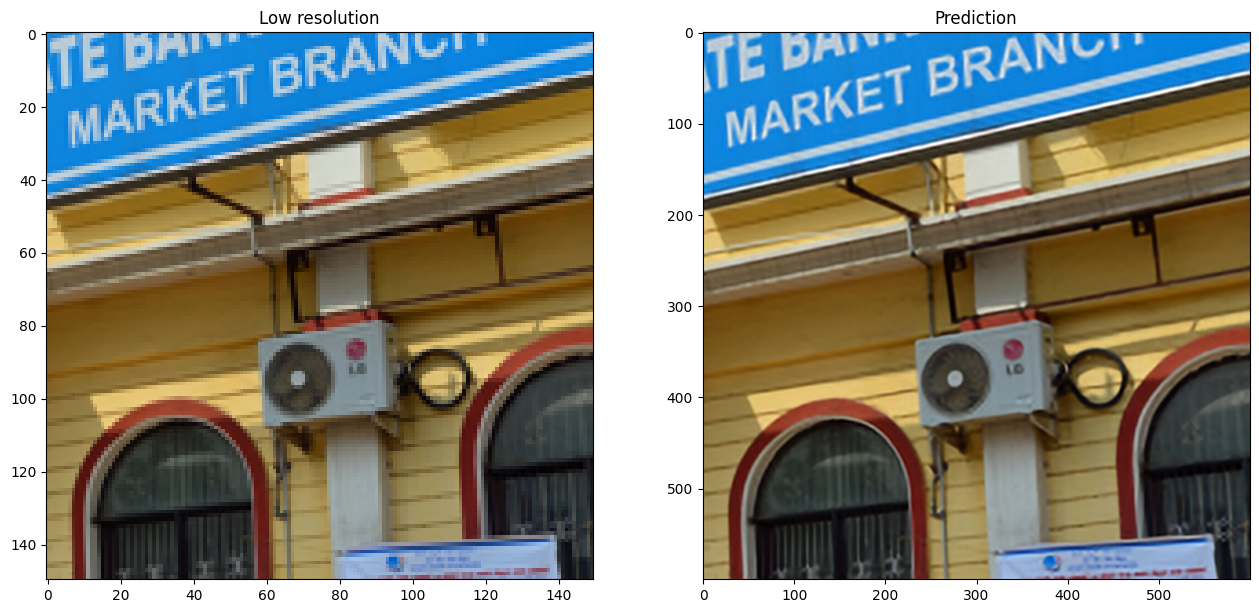

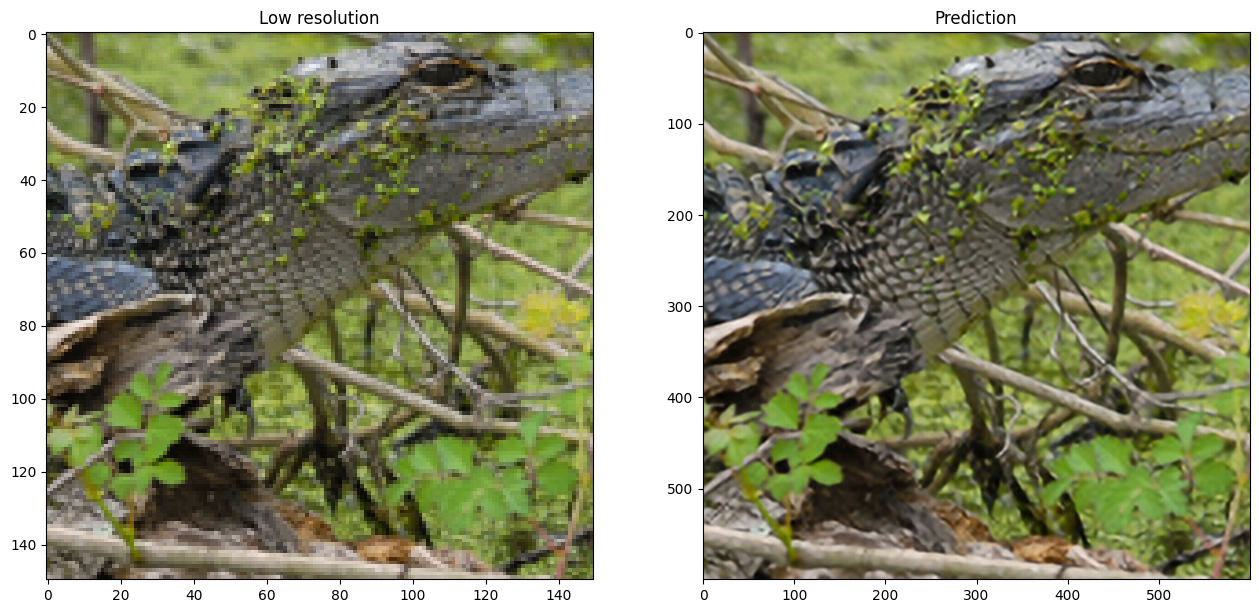

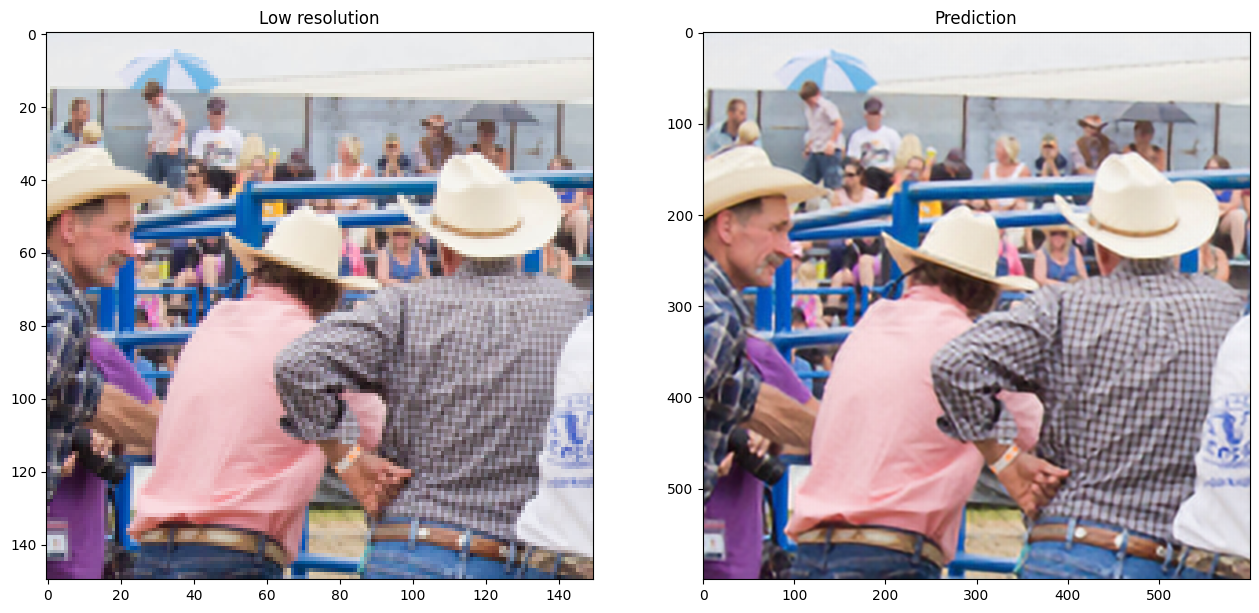

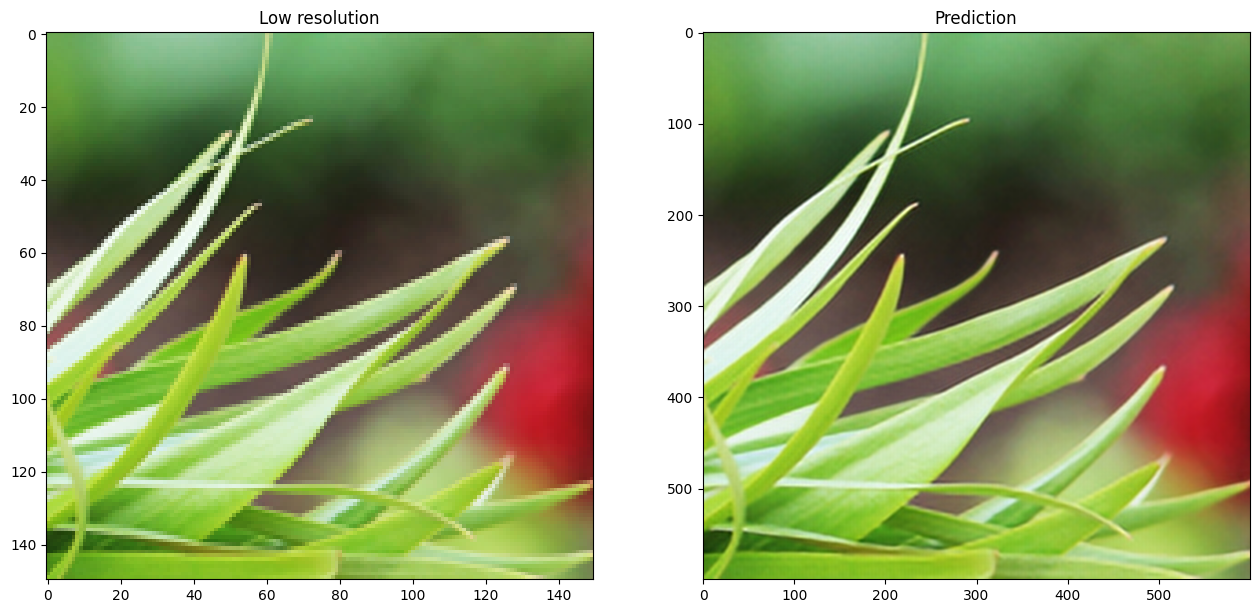

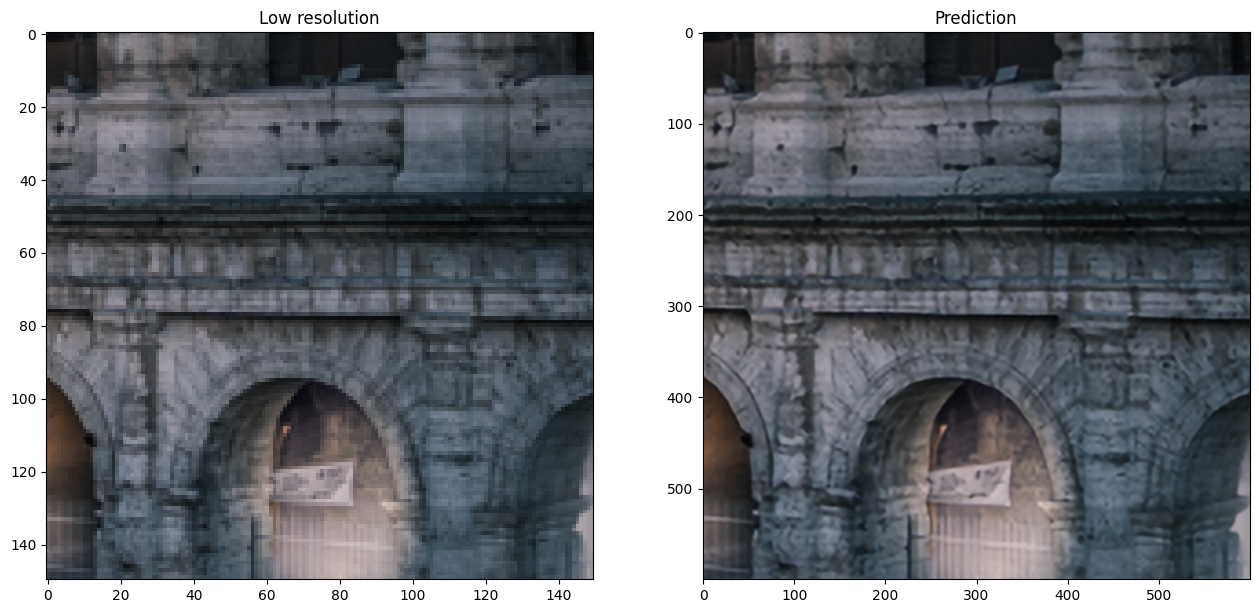

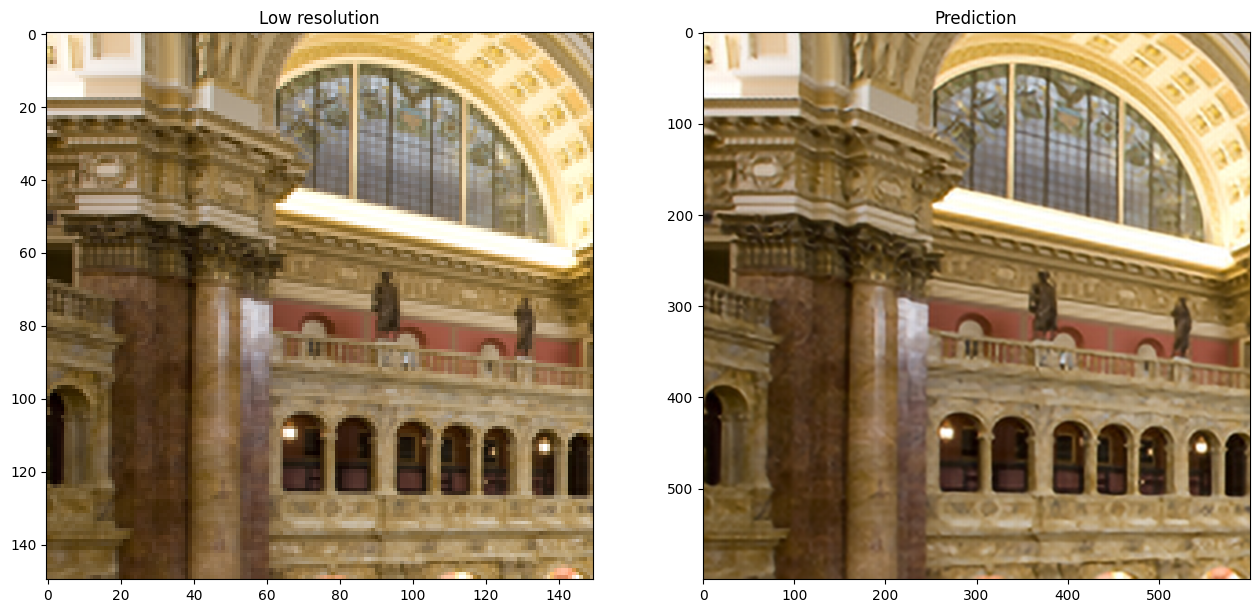

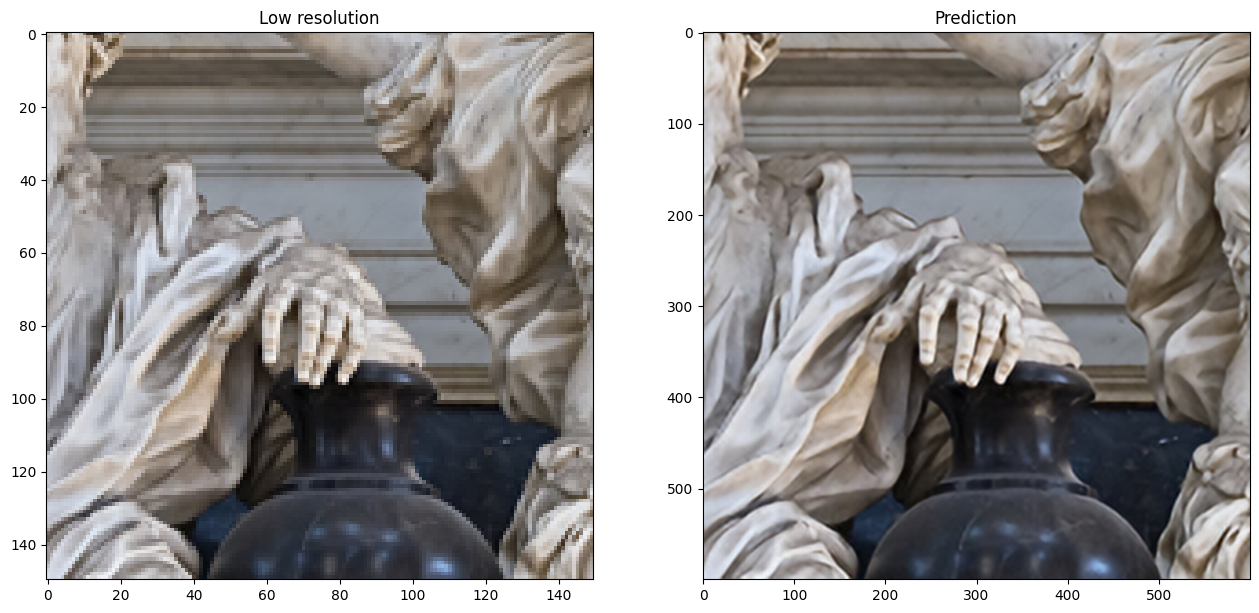

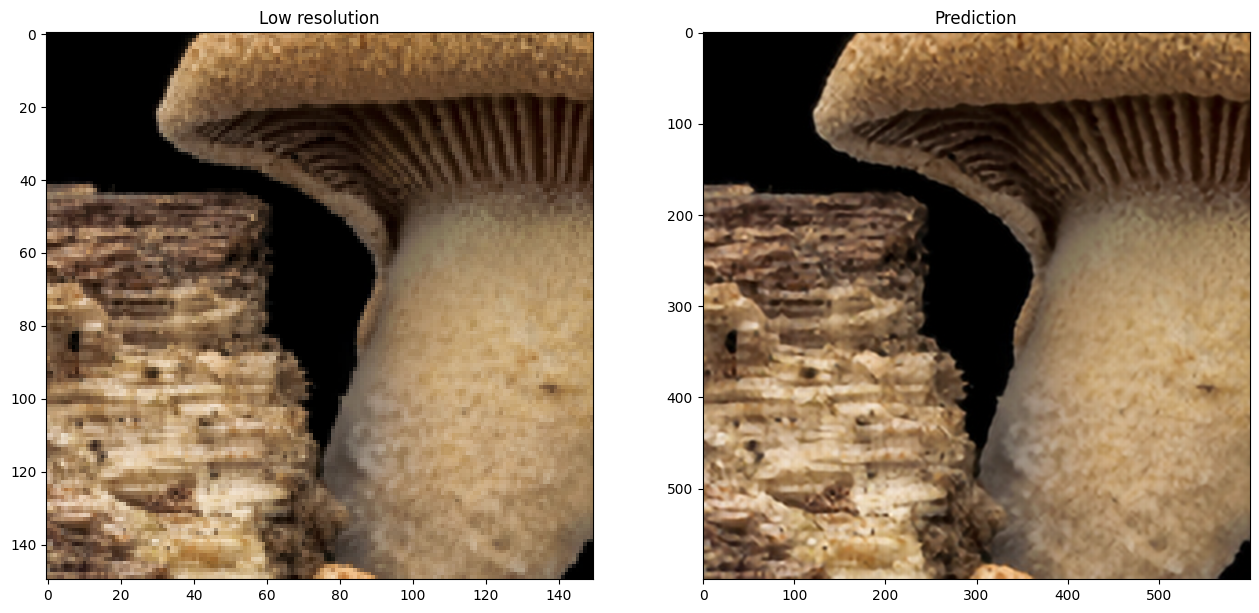

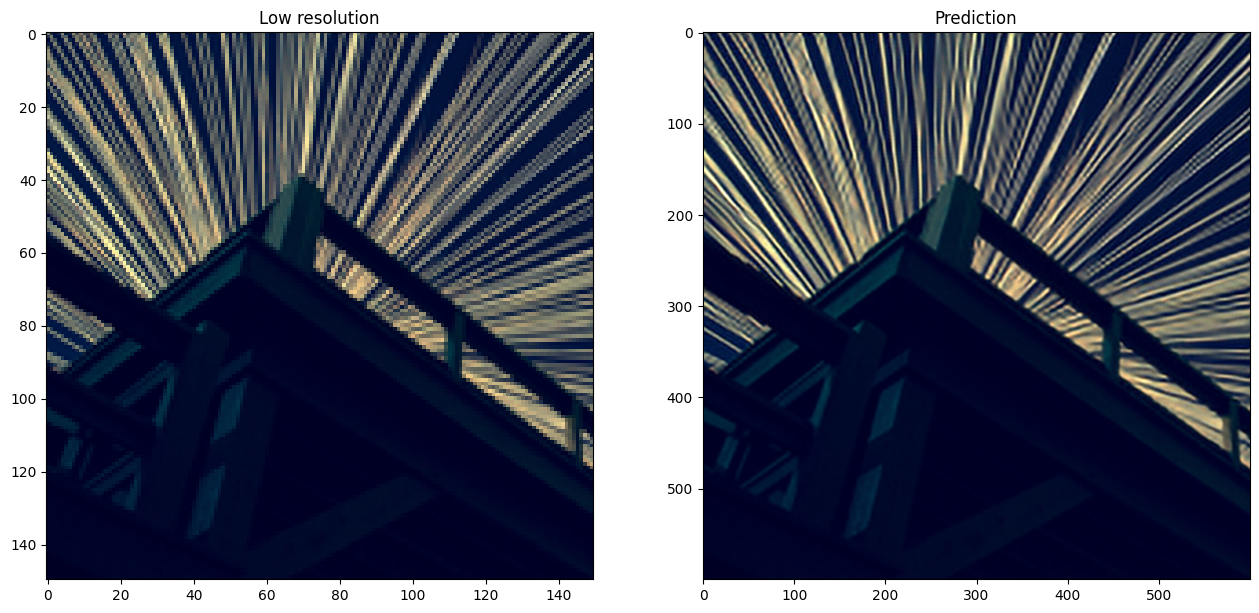

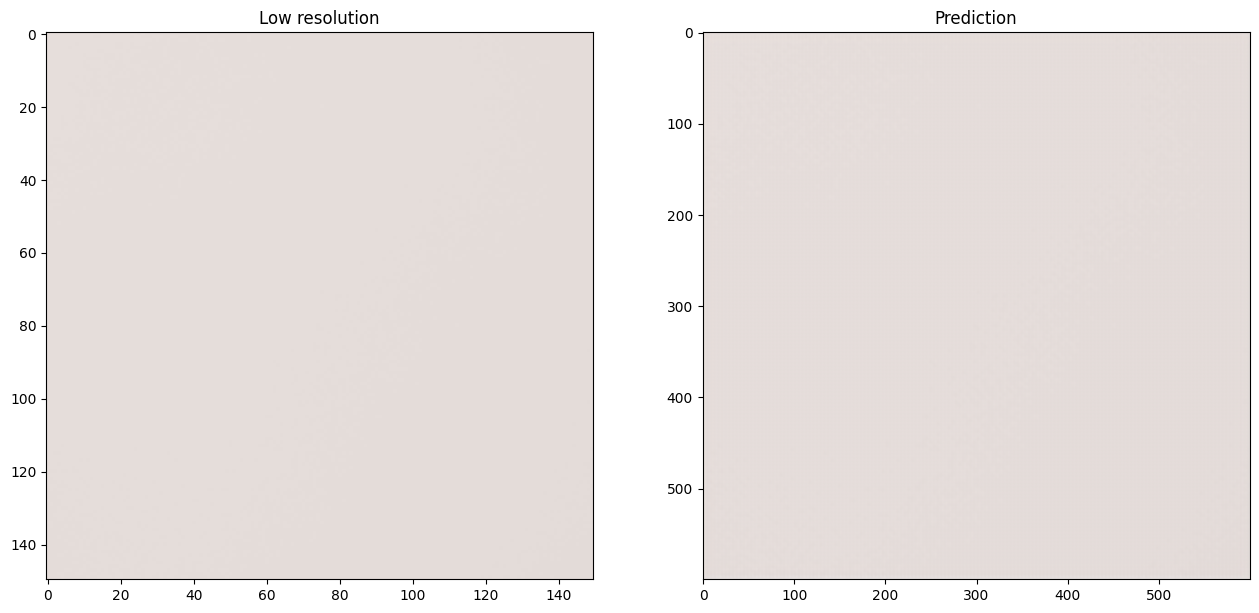

In [8]:
def plot_results(lowres, preds):
    """
    Displays low resolution image and super resolution image
    """
    plt.figure(figsize=(24, 14))
    plt.subplot(132), plt.imshow(lowres), plt.title("Low resolution")
    plt.subplot(133), plt.imshow(preds), plt.title("Prediction")
    plt.show()


for lowres, highres in val.take(10):
    lowres = tf.image.random_crop(lowres, (150, 150, 3))
    preds = model.predict_step(lowres)
    plot_results(lowres, preds)